# ML Example (MNIST)

## Intro

In this notebook we'll be designing and creating a simple neural network to recognize handwritten numbers using the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset.
Neural networks are powerful computing systems which are vaguley inspired by the neurons in our brains!

Neural networks are a sequence of matrix multiplications. So our goal in training one is to "learn" coefficients which make our network an accurate predictor of the data. However, there's a lot that goes into how we can best "learn" those coefficients, so we'll stick to a pretty simple implementation of a nerual net.

The contents of this notebook are a little outside of the scope of what our club does, but we'll do our best to give you a rundown of what the code does.

We'll also have some links at the bottom if you're interested in reading more!

## High Level Explanation

Here's a pretty common visualization of how a neural network looks like:

![Neural network visualization](assets\nn.png)

A neural network can be categorized into three parts:
- Input Layer: The data we feed into this network
- Hidden Layer: This 'layer' can be huge, and is where all the heavy computation happens
- Output Layer: Tells us what our neural network came up with. This layer may be a number or a [one-hot](https://en.wikipedia.org/wiki/One-hot) encoded vector depending on our needs.

Each of these layers contain nodes, which can be their own functions. Links connect nodes between layers.

Computations are passed between these layers in two ways:
- Forward Pass: Compute the output of the network from given input
- Backward Pass: Compute error from our forward pass output and expected output. Use an optimizer to update our weights in the network. This is also referred to as backpropagation.

Our neural network is a convolutional neural network. And we'll use convolutions to isolate certain parts of our data.

At a high level, this is what our neural network does (read bottom-up):

![CNN visulatiozation](assets\cnn.png)

1. We take in our input image
2. Do a convolution over the original image to isolate features.
3. Summarize our convolutions using pooling.
4. Repeat 2-3.
5. Throw output of 4. into a neural network which looks like our first visualization of a neural network.
6. Determine our output.

Our output ends up being a list of 10 floats, which represent scores on how likely an input matches an index. So if we have an output which looks like:

```
[0.3, 0.9, 0.1, 0.0, 0.1, 0.1, 0.6, 0.7, 0.8, 0.7]
```
We would assign the label `1` to the input.

## Setup

We'll be using PyTorch to run our nerual network. Machine Learning requires a lot of disgusting math, so we want to use libraries to do the heavy lifting for us whenever possible.

[PyTorch](https://pytorch.org/) and [TensorFlow](https://www.tensorflow.org/) are both great libraries which make machine learning a lot easier to do. They provide high-level APIs for creating, training, and evaluating models. There's no strong case for why we use PyTorch here, but we do.

In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

Next we'll define our hyperparameters, which are the constants that our model will be based off of. Let's go through them one by one:
- `n_epochs`: The number of times (epochs) we'll run our entire dataset over our model during training.
- `batch_size_train`: Number of samples which will be thrown into the network at a time. We typically don't throw in entire datasets when training models because networks will use less memory and train faster (network will update more often) when working with smaller sample sizes. This is an important consideration, as it introduces some variance to our model if we train it multiple times.
- `batch_size_test`: Same as above. When we test our model we're not doing as intense computations, so we don't care as much for optimizing for speed.
- `learning_rate`: A very 'behind-the-scenes' hyperparameter. Specifies how big our step size is when doing our optimization.
- `momentum`: Another 'behind-the-scenes` hyperparameter. Helps us to converge to our results faster

The remainder of this cell aren't vitally important to the model.

In [2]:
# set hyperparameters
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5

log_interval = 10
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

Next we'll import our data using PyTorch's built in data loading features.

PyTroch will download the data if we don't already have it! Very cool.

In [3]:
# Gather datasets
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.ToTensor()),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Now we can do some data exploration. This is useful for finding out how you can work with the data.

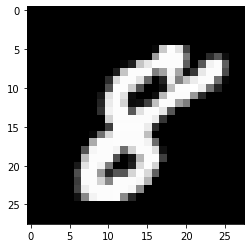

In [9]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
plt.imshow(example_data[0][0], cmap='gray')

## Neural network code

Next we'll define what our neural network looks like using PyTorch's API for models.

After that we'll create some logging data structures.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [12]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [13]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    # Do forward pass
    output = network(data)

    # Find the error of our forward pass' output
    loss = F.nll_loss(output, target)

    # Update our weights using backward pass
    loss.backward()
    optimizer.step()

    # Log out our progress every log_interval setps
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [14]:
def test():
    # Put our network in evaluation mode - won't try to update weights
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now that all the setup's done. We'll shove our dataset through our training and testing functions.

In [16]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.3133, Accuracy: 780/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317615
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.301927
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.306327
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299474
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.304274
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.295260
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.308753
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.309463
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.295531
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.286722
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282758
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.283115
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.255965
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.235591
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.274907
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.244922
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.195050
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.223797
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.185098
Train Epoch: 1 [12160/6

At this point we have a trained model, so we can celebrate by labeling some data points!

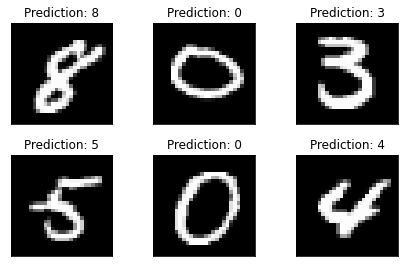

In [17]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

## Links
[Cool Slides for ML (Check out Neural Networks and Structured Neural Networks)](https://courses.cs.washington.edu/courses/cse446/20sp/schedule/)